The goal of the project is to identify and classify toxic online comments. The project is based on the dataset from Jigsaw's Toxic Comment ClassificationChallenge, organized by Kaggle. See more information about this contest and brief dataset analysis in the notebook MScA_32017_AMLAI_TC2_DataOverview.ipynb.

**Data**

Download data from kaggle.com:

*train.csv, test.csv, test_labels.csv.*

Train and test data files format is shown in the notebook *MScA_32017_AMLAI_TC2_DataOverview.ipynb.* 

Note that part of test data was moved to the train after test labels disclosure. Modified files were created there as tc_train.csv and tc_test.csv.


In [1]:
!pip --disable-pip-version-check install transformers
!pip --disable-pip-version-check install datasets

  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


**Import Libraries**

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pickle
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import roc_auc_score

In [3]:
from transformers import AutoTokenizer, TFAutoModel, logging
import tensorflow as tf
from tensorflow.keras import Model, Input 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

**Set Working Directories**

In [4]:
Rcc=True
if not Rcc:
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
# the base Google Drive directory
MODEL =  'distilbert-base-uncased'
if not Rcc:
    root_dir = "/content/drive/My Drive/"
    # choose where you want your project files to be saved
    project_folder = "Colab Notebooks/ADVML/ToxicComments/code/"
    data_folder = "Colab Notebooks/ADVML/ToxicComments/data/"
    model_path=root_dir+MODEL
    #!ls -l "/content/drive/My Drive/Colab Notebooks/ADVML/ToxicComments/data"
else:
    root_dir = "/cloud/msca-gcp/surendiran/"
    # choose where you want your project files to be saved
    project_folder = "toxicComments/code/"
    data_folder = "toxicComments/data/"
    model_path=project_folder+MODEL
   

In [7]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!
def set_WD(project_folder):
    # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\nYou can also run !pwd to confirm the current working directory." )


def create_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')


In [8]:
create_directory(project_folder)
create_directory(data_folder)
set_WD(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/ADVML/ToxicComments/code/
You can also run !pwd to confirm the current working directory.


In [9]:
#!pwd

/content/drive/My Drive/Colab Notebooks/ADVML/ToxicComments/code


In [10]:
dataPath = root_dir+data_folder
train = pd.read_csv(dataPath + 'tc_train.csv',index_col=0)
train.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0


In [11]:
test = pd.read_csv(dataPath+'tc_test.csv',index_col=0)
#test_labels = pd.read_csv(dataPath+'test_labels.csv',index_col=0)

In [12]:
#print(test.head())

                                                       comment_text
id                                                                 
00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7  == From RfC == \n\n The title is fine as it is...
00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
00017563c3f7919a  :If you have a look back at the source, the in...
00017695ad8997eb          I don't anonymously edit articles at all.


The data contain columns of id, text comment and 6 columns of class indicators which are the target variables.

The target variables are the following types of toxicity:

In [13]:
types = list(train)[1:]
num_classes = len(types)
print(types,num_classes)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] 6


Comments can belong to several classes simultaneously. The following figure shows frequences of the classes in the train set.

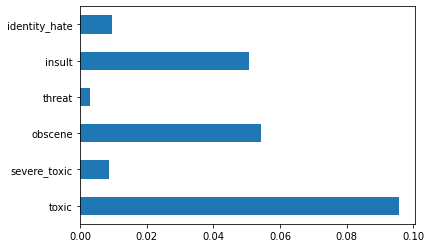

In [14]:
#train[types].mean().plot(kind='barh')

In [15]:
print(train.shape,test.shape)

(223549, 7) (89186, 1)


**Project steps**

**Step 1.**
Download FastText embeddings crawl-300d-2M.vec (see MScA_32017_AMLAI_TC1_NLP_Basics.ipynb).

Step 2.
Using function get_embeddings() from MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb create embeddings index - a dictionary with words as keys and embedding vectors as values.

Step 3.
Preprocess text with the function preprocess() from MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb.
Text preprocessing before creating FastText embeddings includes:

removing digits
isolating punctuation and
replacing consecutive spaces with single one.

Step 4
Using CountVectorizer from sklearn package create the vocabulary of all words from comments except rare ones. (See notebook MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb).

Step 5
Prepare input data for neural network as shown in MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb.

Preparation includes the following actions:

Transform each text to sequence of integer numbers replacing each word with its vocabulary index
Make all vectors same length, truncating sequences longer than defined length and padding shorter ones.

Step 6
Split train data into train and validation sets using the method of multilabel dataset splitting from MScA_32017_AMLAI_TC1_NLP_Basics.ipynb).

Step 7
Create neural network, tune it on train set and make submission. Start with the network architechture from MScA_32017_AMLAI_TC3_WineReviewsExample.ipynb and try to improve it.

Suggestion: learn and try using GlobalAveragePooling1D or GlobalMaxPooling1D layers instead of simple Flatten layer. You may also try to use both of them and concatenate their ouputs.

MaxPooling layer has already been used in Satelite Image Detection project. The only difference between MaxPooling and AveragePooling is that average used instead of maximum.

Step 8
Create neural network based on DistilBert model as shown in MScA_32017_AMLAI_TC6_Wine_Reviews_Bert.ipynb, tune it on train set and make submission. Take a weighted average of this submission and the one obtained on the step 7 to get better score.

In [16]:
print("model_path:", model_path)

/content/drive/My Drive/distilbert-base-uncased


In [17]:
print('Import Transformers')
if RCC:
    modelfolder = MODEL
else:
    modelfolder = os.fspath(model_path)
print(modelfolder)

Import Transformers
/content/drive/My Drive/distilbert-base-uncased


The pretrained models come with their generic tokenizers. The library contains tokenizers for all the models. Most of the tokenizers are available in two flavors: a full python implementation and a “Fast” implementation. The “Fast” implementations allows a significant speed-up in particular when doing batched tokenization and a number of additional methods. If one set parameter use_fast=True (bool, optional, defaults to True) calling AutoTokenizer.from_pretrained method, the fast version of the tokenizer will be downloaded (if any).

Load the model 'distilbert-base-uncased' and fast tokenizer from the repository.

In [18]:
logging.set_verbosity(logging.ERROR)  # suppress warnings, output errors only
transformer = TFAutoModel.from_pretrained(modelfolder)
tokenizer = AutoTokenizer.from_pretrained(modelfolder)
print(transformer)
print(tokenizer)

PreTrainedTokenizerFast(name_or_path='/content/drive/My Drive/distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


**Tokenization**

Transformer models do not require typical preprocessing.
Just call the model specific tokenizer on raw texts.

Create function encode_data() that prepares the text and encodes it.

In [19]:
def encode_data(data, max_len):
    enc_data = tokenizer(data,max_length=max_len, return_token_type_ids=False,
                         padding=True, truncation=True)
    return [np.array(enc_data[k]) for k in ['input_ids','attention_mask']]

In [20]:
MAX_LEN = 512
train_data = encode_data(train['comment_text'].values.tolist(), max_len=MAX_LEN)
test_data = encode_data(test['comment_text'].values.tolist(), max_len=MAX_LEN)

**Build a classifier using pretrained DistilBERT**

Now build a classifier model using the pretrained transformer.
DistilBERT model ouput is in the form of a tuple.

####

Since transformer requires both input_ids and attention_mask, we can implement it as Keras model with two inputs. For the purpose of classification of texts it is enough to select just the first vector from the output of the DistilBERT model: attention associated with the first token [CLS] of the text.
Pass this vector to the Dense layer with single unit and sigmoid activation which actually implements a logistic regression model.
The function get_model() creates and compiles the model.

In [21]:
def get_model(transformer):
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    input_att_mask = Input(shape=(MAX_LEN,), dtype=tf.int8, name="input_att_mask")
    transformer.trainable = False
    x = transformer([input_word_ids,input_att_mask])[0][:, 0, :]  
    out = Dense(num_classes, activation='sigmoid',name = 'custom_dense')(x)
    model = Model(inputs=[input_word_ids,input_att_mask], outputs=out)
    model.compile(loss="binary_crossentropy", 
                  optimizer=Adam(learning_rate=1e-4))
    return model

The output of get_model(transformer) is the model consisting of two parts. Backbone - DistilBERT model with pretrained weights creating the feature and the "classification head" which is a "custom" trainable dense layer with randomly initiated weights.
Model fitting is a two-step procedure.
During step 1 the pretrained DistilBERT weights are frozen (transformer.trainable = False) and only the classification head is trained with learning_rate = 0.001. During step 2 all weights get trained, including the weights of the DistilBERT model.

**Split the train data into train and validation parts**

In [22]:
labels =  train[types].values
labels

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [23]:
id_train,id_test,att_train,att_test,y_train,y_test = train_test_split(train_data[0], train_data[1],
                labels, test_size=0.2)
X_train, X_test = [id_train,att_train],[id_test,att_test]

**Train the model**

Step 1. Classification head training.
During this step train only the classifier head.



In [24]:
best_model_path = 'ToxicComments_best_model_DistillBERT.h5'
# save the best model to a file
chp = ModelCheckpoint(best_model_path,save_best_only=True,save_weights_only=True)
model = get_model(transformer)
print('Model: classifier head traning only: \n',model.summary())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

**Step 1. Fine-tuning of all parameters**


Now make all weights trainable and train the model for 3 more epochs.
For the purposes of fine-tuning, the authors of the BERT paper recommend choosing low learnig rate, typicaly from 2e-5 to 5e-5.
They also note that fine-tuning on the small datasets may be unstable and requires several runs.

Make the DistilBERT model trainable.

In [39]:
model.trainable = True
model.compile(loss="binary_crossentropy", 
              optimizer=Adam(learning_rate=2e-4), metrics=["acc","AUC"])
print('Model: transformer and classifier traning together: \n',
      model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_att_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_word_ids[0][0]             
                                                                 input_att_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

In [42]:
np.shape(X_train)

(2, 178839, 512)

In [73]:
np.array(X_train)[0:2][0:10000,:][0:10000,:].shape

(2, 178839, 512)

In [ ]:
BATCH_SIZE = 64
chp = ModelCheckpoint(best_model_path,save_best_only=True,save_weights_only=True)
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                epochs=3, batch_size=BATCH_SIZE, shuffle=True, verbose=1,
                callbacks=[chp])

Epoch 1/3
  13/5589 [..............................] - ETA: 93:53:00 - loss: 0.2236 - acc: 0.3389 - auc: 0.6661

In [ ]:
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('AUC after head finetuning',roc_auc_score(y_test, test_pred))

In [ ]:
# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

In [ ]:
def compute_aucs(predictions, labels):
    num_classes = predictions.shape[1]
    aucs = np.zeros(num_classes)
    for i in range(num_classes):
        aucs[i] = roc_auc_score(labels[:, i], predictions[:, i])
    return aucs

In [ ]:
compute_aucs(test_pred,types)

** Predict Test Data**

In [ ]:
test_predictions = model.predict(test_data)

Submission File
For each id in the tc_test.csv file predict probability for each of the six possible types of comment toxicity ("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"). Columns must be in the same order as shown below. The file should contain header and have the following format:

**id,toxic,severe_toxic,obscene,threat,insult,identity_hate**

*00001cee341fdb12,0.8,0.5,0.7,0.5,0.5,0.5*

*0000247867823ef7,0.005,0.5,0.11,0.5,0.5,0.5 etc.*

In [ ]:
test_id['id'] = test.index
test_withpredict = pd.concat([test_id, pd.DataFrame(test_predictions)], axis=1)
test_withpredict = ['id', types]

In [ ]:
test_withpredict.head()

Evaluation
Submissions are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.
ROC AUC of your submission should be greater than 0.98 to get 100 points.

Upload the saved file using shiny test application.

In [ ]:
#np.savetxt(dataPath+'submission.csv', test_class_pred, fmt='%d', delimiter=',')

In [ ]:
test_withpredict.to_csv(dataPath+'toxiccomments_test_submission.csv')

In [ ]:
#submission['id'] = test.index
#submission['toxic'] = test_pred[0:, 0]
#submission['severe_toxic'] = test_pred[0:, 1]
#submission['obscene'] = test_pred[0:, 2]
#submission['threat'] = test_pred[0:, 3]
#submission['insult'] = test_pred[0:, 4]
#submission['identity_hate'] = test_pred[0:, 5]
#submission.to_csv('submission.csv', sep = ',', index = False)